In [30]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet101

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained DeepLabV3+ model
model = deeplabv3_resnet101(pretrained=True).eval().to(device)

In [31]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [32]:
print("Using", device)
print("Model loaded:", model.__class__.__name__)


Using cuda
Model loaded: DeepLabV3


In [33]:
import rasterio
from rasterio.windows import Window
import numpy as np

def get_tiles(width, height, tile_size=512, stride=512):
    for top in range(0, height, stride):
        for left in range(0, width, stride):
            # Calculate actual tile dimensions (may be smaller at edges)
            actual_width = min(tile_size, width - left)
            actual_height = min(tile_size, height - top)
            
            # Skip tiles that are too small
            if actual_width < tile_size // 2 or actual_height < tile_size // 2:
                continue
                
            yield Window(left, top, actual_width, actual_height), (left, top)

In [34]:
import numpy as np
def segment_forest(model, crop):
    # Get actual dimensions
    bands, height, width = crop.shape
    
    # Pad to 512x512 if needed
    if height != 512 or width != 512:
        padded_crop = np.zeros((bands, 512, 512), dtype=crop.dtype)
        padded_crop[:, :height, :width] = crop
        crop = padded_crop
    
    rgb = np.transpose(crop[:3], (1, 2, 0)) / 255.0
    rgb = rgb.astype(np.float32)
    tensor = preprocess(rgb).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(tensor)['out'][0]
    
    # Get only the valid region (crop back to original size)
    mask = (output.argmax(0).cpu().numpy() == 21)
    return mask[:height, :width]  # Return only the valid region

In [35]:
from tqdm import tqdm
import numpy as np

loss_map = []
coords_map = []

with rasterio.open("../data/naip_before.tif") as src_before, \
     rasterio.open("../data/naip_after.tif") as src_after:

    width, height = src_before.width, src_before.height

    for window, (x, y) in tqdm(get_tiles(width, height)):
        before_crop = src_before.read(window=window)
        after_crop  = src_after.read(window=window)
        
        # Debug: Check if crops have the same shape
        print(f"Before crop shape: {before_crop.shape}")
        print(f"After crop shape: {after_crop.shape}")

        mask_before = segment_forest(model, before_crop)
        mask_after  = segment_forest(model, after_crop)

        # Get the minimum dimensions
        min_h = min(mask_before.shape[0], mask_after.shape[0])
        min_w = min(mask_before.shape[1], mask_after.shape[1])

        # Crop both masks to the same size
        mask_before = mask_before[:min_h, :min_w]
        mask_after = mask_after[:min_h, :min_w]
        
        # Debug: Check if masks have the same shape
        print(f"Before mask shape: {mask_before.shape}")
        print(f"After mask shape: {mask_after.shape}")

        loss = ((mask_before == 1) & (mask_after == 0)).sum()
        total = (mask_before == 1).sum()
        loss_percent = 100 * loss / total if total else 0

        loss_map.append(loss_percent)
        coords_map.append((x, y))

0it [00:00, ?it/s]

Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


1it [00:00,  5.90it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


2it [00:00,  6.76it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


3it [00:00,  7.10it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


4it [00:00,  7.41it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


5it [00:00,  7.59it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


6it [00:00,  7.63it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


7it [00:00,  7.74it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


8it [00:01,  7.78it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


9it [00:01,  7.81it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


10it [00:01,  7.82it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


11it [00:01,  7.80it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


12it [00:01,  7.81it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


13it [00:01,  7.84it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


14it [00:01,  7.86it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


15it [00:01,  7.87it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


16it [00:02,  7.87it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


17it [00:02,  7.89it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


18it [00:02,  7.87it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


19it [00:02,  7.88it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


20it [00:02,  7.87it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


21it [00:02,  7.19it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


22it [00:02,  7.39it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


23it [00:03,  7.54it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


24it [00:03,  7.63it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


25it [00:03,  7.68it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


26it [00:03,  7.71it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


27it [00:03,  7.74it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


28it [00:03,  7.79it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


29it [00:03,  7.81it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


30it [00:03,  7.84it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


31it [00:04,  7.84it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


32it [00:04,  7.86it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


33it [00:04,  7.87it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


34it [00:04,  7.87it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


35it [00:04,  7.81it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


36it [00:04,  7.82it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


37it [00:04,  7.85it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


38it [00:04,  7.83it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


39it [00:05,  7.77it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


40it [00:05,  7.78it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


41it [00:05,  7.12it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


42it [00:05,  7.24it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


43it [00:05,  7.42it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


44it [00:05,  7.56it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


45it [00:05,  7.65it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


46it [00:05,  7.71it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


47it [00:06,  7.77it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


48it [00:06,  7.76it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


49it [00:06,  7.79it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


50it [00:06,  7.82it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


51it [00:06,  7.84it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


52it [00:06,  7.85it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


53it [00:06,  7.86it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


54it [00:07,  7.87it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


55it [00:07,  7.88it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


56it [00:07,  7.89it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


57it [00:07,  7.88it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


58it [00:07,  7.88it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


59it [00:07,  7.88it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


60it [00:07,  7.87it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


61it [00:07,  7.19it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


62it [00:08,  7.38it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


63it [00:08,  7.53it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


64it [00:08,  7.66it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


65it [00:08,  7.67it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


66it [00:08,  7.70it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


67it [00:08,  7.73it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


68it [00:08,  7.78it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


69it [00:08,  7.80it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


70it [00:09,  7.79it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


71it [00:09,  7.82it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


72it [00:09,  7.82it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


73it [00:09,  7.82it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


74it [00:09,  7.72it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


75it [00:09,  7.76it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


76it [00:09,  7.77it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


77it [00:09,  7.81it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


78it [00:10,  7.82it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


79it [00:10,  7.83it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


80it [00:10,  7.81it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


81it [00:10,  7.11it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


82it [00:10,  7.31it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


83it [00:10,  7.46it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


84it [00:10,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


85it [00:11,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


86it [00:11,  7.70it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


87it [00:11,  7.70it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


88it [00:11,  7.70it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


89it [00:11,  7.72it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


90it [00:11,  7.74it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


91it [00:11,  7.76it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


92it [00:11,  7.77it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


93it [00:12,  7.79it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


94it [00:12,  7.79it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


95it [00:12,  7.81it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


96it [00:12,  7.81it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


97it [00:12,  7.82it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


98it [00:12,  7.82it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


99it [00:12,  7.82it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


100it [00:12,  7.81it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


101it [00:13,  7.20it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


102it [00:13,  7.37it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


103it [00:13,  7.48it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


104it [00:13,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


105it [00:13,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


106it [00:13,  7.70it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


107it [00:13,  7.74it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


108it [00:14,  7.77it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


109it [00:14,  7.80it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


110it [00:14,  7.79it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


111it [00:14,  7.62it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


112it [00:14,  7.66it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


113it [00:14,  7.69it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


114it [00:14,  7.70it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


115it [00:14,  7.72it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


116it [00:15,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


117it [00:15,  7.63it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


118it [00:15,  7.66it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


119it [00:15,  7.69it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


120it [00:15,  7.66it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


121it [00:15,  7.00it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


122it [00:15,  7.23it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


123it [00:16,  7.40it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


124it [00:16,  7.52it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


125it [00:16,  7.55it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


126it [00:16,  7.61it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


127it [00:16,  7.68it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


128it [00:16,  7.72it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


129it [00:16,  7.75it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


130it [00:16,  7.78it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


131it [00:17,  7.77it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


132it [00:17,  7.75it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


133it [00:17,  7.73it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


134it [00:17,  7.70it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


135it [00:17,  7.71it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


136it [00:17,  7.69it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


137it [00:17,  7.72it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


138it [00:17,  7.73it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


139it [00:18,  7.75it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


140it [00:18,  7.74it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


141it [00:18,  7.12it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


142it [00:18,  7.29it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


143it [00:18,  7.43it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


144it [00:18,  7.54it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


145it [00:18,  7.61it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


146it [00:19,  7.67it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


147it [00:19,  7.71it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


148it [00:19,  7.73it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


149it [00:19,  7.75it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


150it [00:19,  7.76it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


151it [00:19,  7.76it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


152it [00:19,  7.77it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


153it [00:19,  7.77it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


154it [00:20,  7.77it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


155it [00:20,  7.77it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


156it [00:20,  7.77it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


157it [00:20,  7.73it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


158it [00:20,  7.72it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


159it [00:20,  7.67it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


160it [00:20,  7.38it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


161it [00:21,  6.85it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


162it [00:21,  7.11it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


163it [00:21,  7.24it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


164it [00:21,  7.38it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


165it [00:21,  7.46it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


166it [00:21,  7.53it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


167it [00:21,  7.60it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


168it [00:21,  7.63it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


169it [00:22,  7.65it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


170it [00:22,  7.68it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


171it [00:22,  7.71it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


172it [00:22,  7.70it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


173it [00:22,  7.69it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


174it [00:22,  7.70it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


175it [00:22,  7.72it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


176it [00:22,  7.74it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


177it [00:23,  7.75it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


178it [00:23,  7.77it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


179it [00:23,  7.78it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


180it [00:23,  7.77it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


181it [00:23,  7.07it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


182it [00:23,  7.26it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


183it [00:23,  7.40it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


184it [00:24,  7.51it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


185it [00:24,  7.58it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


186it [00:24,  7.62it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


187it [00:24,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


188it [00:24,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


189it [00:24,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


190it [00:24,  7.65it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


191it [00:24,  7.68it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


192it [00:25,  7.71it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


193it [00:25,  7.72it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


194it [00:25,  7.73it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


195it [00:25,  7.75it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


196it [00:25,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


197it [00:25,  7.67it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


198it [00:25,  7.69it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


199it [00:25,  7.69it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


200it [00:26,  7.66it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


201it [00:26,  7.09it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


202it [00:26,  7.27it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


203it [00:26,  7.39it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


204it [00:26,  7.46it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


205it [00:26,  7.53it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


206it [00:26,  7.60it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


207it [00:27,  7.65it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


208it [00:27,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


209it [00:27,  7.66it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


210it [00:27,  7.63it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


211it [00:27,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


212it [00:27,  7.67it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


213it [00:27,  7.69it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


214it [00:27,  7.71it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


215it [00:28,  7.72it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


216it [00:28,  7.73it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


217it [00:28,  7.72it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


218it [00:28,  7.72it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


219it [00:28,  7.73it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


220it [00:28,  7.69it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


221it [00:28,  7.04it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


222it [00:29,  7.23it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


223it [00:29,  7.35it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


224it [00:29,  7.47it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


225it [00:29,  7.51it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


226it [00:29,  7.54it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


227it [00:29,  7.58it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


228it [00:29,  7.61it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


229it [00:29,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


230it [00:30,  7.67it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


231it [00:30,  7.66it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


232it [00:30,  7.68it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


233it [00:30,  7.69it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


234it [00:30,  7.71it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


235it [00:30,  7.70it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


236it [00:30,  7.71it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


237it [00:31,  7.68it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


238it [00:31,  7.70it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


239it [00:31,  7.70it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


240it [00:31,  7.66it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


241it [00:31,  7.02it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


242it [00:31,  7.17it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


243it [00:31,  7.32it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


244it [00:31,  7.41it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


245it [00:32,  7.45it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


246it [00:32,  7.52it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


247it [00:32,  7.58it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


248it [00:32,  7.62it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


249it [00:32,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


250it [00:32,  7.66it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


251it [00:32,  7.68it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


252it [00:33,  7.68it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


253it [00:33,  7.70it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


254it [00:33,  7.69it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


255it [00:33,  7.68it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


256it [00:33,  7.67it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


257it [00:33,  7.67it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


258it [00:33,  7.67it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


259it [00:33,  7.69it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


260it [00:34,  7.64it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


261it [00:34,  7.08it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


262it [00:34,  7.24it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


263it [00:34,  7.34it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


264it [00:34,  7.42it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


265it [00:34,  7.49it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


266it [00:34,  7.52it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


267it [00:35,  7.56it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


268it [00:35,  7.59it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


269it [00:35,  7.61it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


270it [00:35,  7.63it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


271it [00:35,  7.62it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


272it [00:35,  7.56it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


273it [00:35,  7.61it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


274it [00:35,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


275it [00:36,  7.66it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


276it [00:36,  7.67it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


277it [00:36,  7.66it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


278it [00:36,  7.54it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


279it [00:36,  7.48it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


280it [00:36,  7.53it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


281it [00:36,  6.94it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


282it [00:37,  7.15it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


283it [00:37,  7.31it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


284it [00:37,  7.42it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


285it [00:37,  7.50it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


286it [00:37,  7.52it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


287it [00:37,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


288it [00:37,  7.59it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


289it [00:37,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


290it [00:38,  7.65it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


291it [00:38,  7.65it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


292it [00:38,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


293it [00:38,  7.63it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


294it [00:38,  7.56it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


295it [00:38,  7.60it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


296it [00:38,  7.62it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


297it [00:38,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


298it [00:39,  7.65it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


299it [00:39,  7.65it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


300it [00:39,  7.65it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


301it [00:39,  6.98it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


302it [00:39,  7.17it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


303it [00:39,  7.31it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


304it [00:39,  7.42it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


305it [00:40,  7.47it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


306it [00:40,  7.53it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


307it [00:40,  7.56it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


308it [00:40,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


309it [00:40,  7.60it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


310it [00:40,  7.62it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


311it [00:40,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


312it [00:40,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


313it [00:41,  7.63it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


314it [00:41,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


315it [00:41,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


316it [00:41,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


317it [00:41,  7.66it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


318it [00:41,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


319it [00:41,  7.62it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


320it [00:42,  7.63it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


321it [00:42,  7.02it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


322it [00:42,  7.20it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


323it [00:42,  7.32it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


324it [00:42,  7.42it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


325it [00:42,  7.48it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


326it [00:42,  7.49it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


327it [00:42,  7.52it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


328it [00:43,  7.50it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


329it [00:43,  7.54it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


330it [00:43,  7.53it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


331it [00:43,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


332it [00:43,  7.60it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


333it [00:43,  7.62it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


334it [00:43,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


335it [00:44,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


336it [00:44,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


337it [00:44,  7.65it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


338it [00:44,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


339it [00:44,  7.65it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


340it [00:44,  7.65it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


341it [00:44,  7.08it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


342it [00:44,  7.25it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


343it [00:45,  7.34it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


344it [00:45,  7.44it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


345it [00:45,  7.49it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


346it [00:45,  7.55it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


347it [00:45,  7.58it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


348it [00:45,  7.58it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


349it [00:45,  7.60it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


350it [00:46,  7.62it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


351it [00:46,  7.63it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


352it [00:46,  7.63it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


353it [00:46,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


354it [00:46,  7.63it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


355it [00:46,  7.63it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


356it [00:46,  7.64it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


357it [00:46,  7.65it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


358it [00:47,  7.62it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


359it [00:47,  7.62it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


360it [00:47,  7.62it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


361it [00:47,  7.04it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


362it [00:47,  7.18it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


363it [00:47,  7.31it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


364it [00:47,  7.41it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


365it [00:48,  7.46it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


366it [00:48,  7.49it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


367it [00:48,  7.53it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


368it [00:48,  7.56it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


369it [00:48,  7.58it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


370it [00:48,  7.60it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


371it [00:48,  7.60it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


372it [00:48,  7.61it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


373it [00:49,  7.61it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


374it [00:49,  7.62it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


375it [00:49,  7.61it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


376it [00:49,  7.61it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


377it [00:49,  7.62it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


378it [00:49,  7.61it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


379it [00:49,  7.62it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


380it [00:50,  7.61it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


381it [00:50,  7.06it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


382it [00:50,  7.22it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


383it [00:50,  7.33it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


384it [00:50,  7.40it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


385it [00:50,  7.46it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


386it [00:50,  7.51it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


387it [00:50,  7.54it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


388it [00:51,  7.55it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


389it [00:51,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


390it [00:51,  7.58it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


391it [00:51,  7.59it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


392it [00:51,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


393it [00:51,  7.59it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


394it [00:51,  7.59it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


395it [00:52,  7.59it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


396it [00:52,  7.61it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


397it [00:52,  7.60it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


398it [00:52,  7.61it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


399it [00:52,  7.61it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


400it [00:52,  7.60it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


401it [00:52,  6.67it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


402it [00:52,  6.91it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


403it [00:53,  7.11it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


404it [00:53,  7.24it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


405it [00:53,  7.32it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


406it [00:53,  7.39it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


407it [00:53,  7.44it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


408it [00:53,  7.49it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


409it [00:53,  7.52it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


410it [00:54,  7.54it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


411it [00:54,  7.54it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


412it [00:54,  7.56it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


413it [00:54,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


414it [00:54,  7.58it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


415it [00:54,  7.58it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


416it [00:54,  7.58it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


417it [00:54,  7.58it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


418it [00:55,  7.58it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


419it [00:55,  7.52it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


420it [00:55,  7.55it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


421it [00:55,  6.99it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


422it [00:55,  7.17it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


423it [00:55,  7.29it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


424it [00:55,  7.38it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


425it [00:56,  7.44it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


426it [00:56,  7.47it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


427it [00:56,  7.49it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


428it [00:56,  7.52it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


429it [00:56,  7.52it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


430it [00:56,  7.54it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


431it [00:56,  7.55it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


432it [00:56,  7.56it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


433it [00:57,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


434it [00:57,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


435it [00:57,  7.58it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


436it [00:57,  7.59it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


437it [00:57,  7.58it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


438it [00:57,  7.59it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


439it [00:57,  7.59it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


440it [00:58,  7.58it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


441it [00:58,  7.04it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


442it [00:58,  7.20it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


443it [00:58,  7.31it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


444it [00:58,  7.39it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


445it [00:58,  7.45it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


446it [00:58,  7.50it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


447it [00:59,  7.53it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


448it [00:59,  7.52it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


449it [00:59,  7.54it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


450it [00:59,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


451it [00:59,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


452it [00:59,  7.56it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


453it [00:59,  7.56it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


454it [00:59,  7.56it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


455it [01:00,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


456it [01:00,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


457it [01:00,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


458it [01:00,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


459it [01:00,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


460it [01:00,  7.57it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


461it [01:00,  6.96it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


462it [01:01,  7.14it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


463it [01:01,  7.25it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


464it [01:01,  7.35it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


465it [01:01,  7.42it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


466it [01:01,  7.47it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


467it [01:01,  7.51it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


468it [01:01,  7.49it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


469it [01:01,  7.52it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


470it [01:02,  7.53it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


471it [01:02,  7.54it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


472it [01:02,  7.56it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


473it [01:02,  7.56it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


474it [01:02,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


475it [01:02,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


476it [01:02,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


477it [01:03,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


478it [01:03,  7.57it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 512)


479it [01:03,  7.58it/s]

Before mask shape: (512, 512)
After mask shape: (512, 512)
Before crop shape: (4, 512, 512)
After crop shape: (4, 512, 402)


480it [01:03,  7.57it/s]

Before mask shape: (512, 402)
After mask shape: (512, 402)


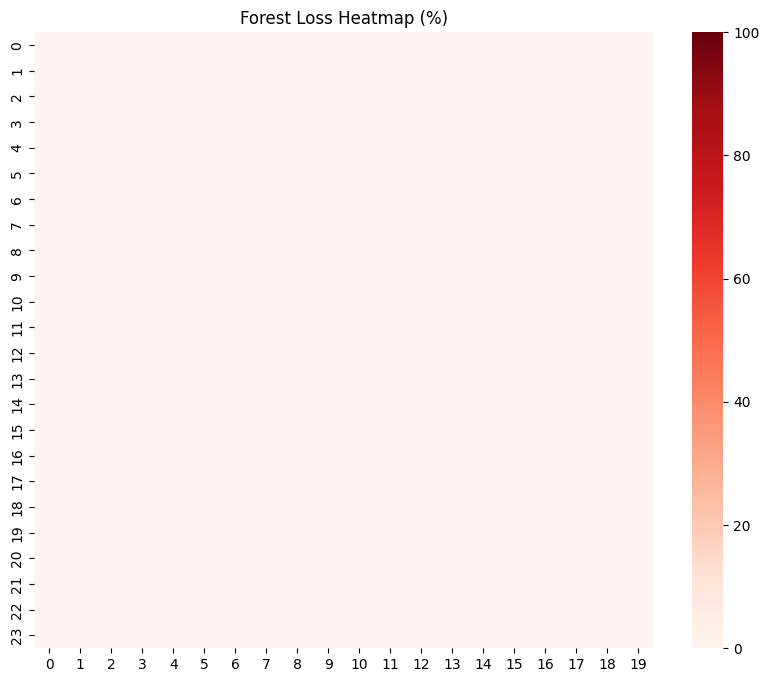

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to 2D grid
grid_w = width // 512
grid_h = height // 512
heatmap = np.zeros((grid_h, grid_w))

for (x, y), loss in zip(coords_map, loss_map):
    col = x // 512
    row = y // 512
    heatmap[row, col] = loss

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap, cmap="Reds", vmin=0, vmax=100)
plt.title("Forest Loss Heatmap (%)")
plt.show()


In [38]:
import pandas as pd
df = pd.DataFrame({
    'x': [c[0] for c in coords_map],
    'y': [c[1] for c in coords_map],
    'loss_percent': loss_map
})
df.to_csv("forest_loss_grid.csv", index=False)
